<a href="https://colab.research.google.com/github/Mariammmmmmm/CourseWork/blob/main/Project_big_data_Copy1_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import socket
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, length, when, col, broadcast
from pyspark.sql.types import BooleanType, IntegerType, LongType, StringType, ArrayType, FloatType, StructType, StructField
import pyspark.sql.functions as F
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import PandasUDFType
from pyspark import StorageLevel
from jinja2 import Environment, FileSystemLoader
import pandas as pd
import datetime

In [ ]:
# setting constants
APP_NAME = "lera_app_new"
NORMALIZED_APP_NAME = APP_NAME.replace('/', '_').replace(':', '_')

APPS_TMP_DIR = os.path.join(os.getcwd(), "tmp")
APPS_CONF_DIR = os.path.join(os.getcwd(), "conf")
APPS_LOGS_DIR = os.path.join(os.getcwd(), "logs")
LOG4J_PROP_FILE = os.path.join(APPS_CONF_DIR, "pyspark-log4j-{}.properties".format(NORMALIZED_APP_NAME))
LOG_FILE = os.path.join(APPS_LOGS_DIR, 'pyspark-{}.log'.format(NORMALIZED_APP_NAME))
EXTRA_JAVA_OPTIONS = "-Dlog4j.configuration=file://{} -Dspark.hadoop.dfs.replication=1 -Dhttps.protocols=TLSv1.0,TLSv1.1,TLSv1.2,TLSv1.3"\
    .format(LOG4J_PROP_FILE)

LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [ ]:
# preparing configuration files from templates
for directory in [APPS_CONF_DIR, APPS_LOGS_DIR, APPS_TMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

env = Environment(loader=FileSystemLoader('/opt'))
template = env.get_template("pyspark_log4j.properties.template")
template\
    .stream(logfile=LOG_FILE)\
    .dump(LOG4J_PROP_FILE)

In [ ]:
# run spark
spark = SparkSession\
    .builder\
    .appName(APP_NAME)\
    .master("k8s://https://10.32.7.103:6443")\
    .config("spark.driver.host", LOCAL_IP)\
    .config("spark.ui.port", "4040")\
    .config("spark.kubernetes.memoryOverheadFactor", "0.6")\
    .config("spark.driver.memory", "10g")\
    .config("spark.driver.bindAddress", "0.0.0.0")\
    .config("spark.executor.instances", "5")\
    .config("spark.executor.cores", '1')\
    .config("spark.executor.memory", "9g")\
    .config("spark.memory.fraction", "0.6")\
    .config("spark.memory.storageFraction", "0.5")\
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")\
    .config("spark.driver.extraJavaOptions", EXTRA_JAVA_OPTIONS)\
    .config("spark.kubernetes.namespace", "vmyslenkova-337998")\
    .config("spark.kubernetes.driver.label.appname", APP_NAME)\
    .config("spark.kubernetes.executor.label.appname", APP_NAME)\
    .config("spark.kubernetes.container.image.pullPolicy", "Always")\
    .config("spark.kubernetes.container.image", "node03.st:5000/spark-executor:vmyslenkova-337998")\
    .config("spark.kubernetes.executor.deleteOnTermination", "true")\
    .config("spark.local.dir", "/tmp/spark")\
    .config("spark.kubernetes.driver.volumes.persistentVolumeClaim.nfs-home-storage.mount.path",'/home/jovyan/nfs-home')\
    .getOrCreate()

In [ ]:
# .config("spark.kubernetes.executor.volumes.nfs.my_tom.mount.path",'/home/jovyan/nltk_data/corpora/wordnet')\
#.config("spark.kubernetes.executor.volumes.nfs.my_tom.mount.subPath",'/nfs/home/vmyslenkova-337998/nltk_data/corpora/wordnet')\
    

In [ ]:
#spark.stop()

In [ ]:
os.getcwd()

'/home/jovyan/nfs-home'

In [ ]:
print("Web UI: {}".format(spark.sparkContext.uiWebUrl))
print("\nlog4j file: {}".format(LOG4J_PROP_FILE))
print("\ndriver log file: {}".format(LOG_FILE))

Web UI: http://10.128.251.38:4040

log4j file: /home/jovyan/nfs-home/conf/pyspark-log4j-lera_app_new.properties

driver log file: /home/jovyan/nfs-home/logs/pyspark-lera_app_new.log


In [ ]:
df_1 = spark.read.json(f"hdfs:///home/vmyslenkova-337998/doc.json")

In [ ]:
df_2 = spark.read.json(f"hdfs:///home/vmyslenkova-337998/doc1.json")

In [ ]:
df_3 = spark.read.json(f"hdfs:///home/vmyslenkova-337998/doc2.json")

In [ ]:
df_4 = spark.read.json(f"hdfs:///home/vmyslenkova-337998/doc3.json")

In [ ]:
df_pyspark = df_1.union(df_2).union(df_3).union(df_4)

In [ ]:
df_pyspark.show(1)

+--------+--------------------+--------------------+-----------+-------+----------+--------------------+------------------+-----+---------+-------------+-------+------------------+--------------------+
|abstract|          author_ids|        author_names|authorgroup|authors|   creator|         description|               eid|index|publisher|subject_areas|subtype|subtypedescription|               title|
+--------+--------------------+--------------------+-----------+-------+----------+--------------------+------------------+-----+---------+-------------+-------+------------------+--------------------+
|    null|7004218797;572081...|Yazdani, A.;Eftek...|       null|   null|Yazdani A.|The reliability o...|2-s2.0-84856856873|    0|     null|         null|     ar|              null|Variance decompos...|
+--------+--------------------+--------------------+-----------+-------+----------+--------------------+------------------+-----+---------+-------------+-------+------------------+------------

In [ ]:
#spark.stop()

In [ ]:
df_pyspark.count()

1604742

In [ ]:
df_pyspark.printSchema()

root
 |-- abstract: string (nullable = true)
 |-- author_ids: string (nullable = true)
 |-- author_names: string (nullable = true)
 |-- authorgroup: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- description: string (nullable = true)
 |-- eid: string (nullable = true)
 |-- index: long (nullable = true)
 |-- publisher: string (nullable = true)
 |-- subject_areas: string (nullable = true)
 |-- subtype: string (nullable = true)
 |-- subtypedescription: string (nullable = true)
 |-- title: string (nullable = true)



In [ ]:
from pyspark.sql.functions import split

In [ ]:
df_pyspark = df_pyspark.select(split(col('author_names'), ';').alias('author_names'), split(col('author_ids'), ';').alias('author_ids'), 'eid', 'description')

In [ ]:
df_pyspark.show(10) 

+--------------------+--------------------+------------------+--------------------+
|        author_names|          author_ids|               eid|         description|
+--------------------+--------------------+------------------+--------------------+
|[Yazdani, A., Eft...|[7004218797, 5720...|2-s2.0-84856856873|The reliability o...|
|[Dehkordi, Massou...|[55667068800, 350...|2-s2.0-84855377268|In order to prote...|
|[Masmoudi, Ahmed,...|[7003830108, 2233...|2-s2.0-84986121023|Purpose – To purp...|
|[Hayat, T., Naz, ...|[8856998000, 5518...|2-s2.0-83255192281|The influence of ...|
|[Karimian, S. M.H...|[57197510735, 572...|2-s2.0-83255187977|In many particle-...|
|  [Dinarvand, Saeed]|       [24502768200]|2-s2.0-83255185870|This paper deals ...|
|[Sadeghian, Hamid...|[57217645052, 700...|2-s2.0-84455203936|This paper presen...|
|[Mobarhani, Amir,...|[27267855400, 568...|2-s2.0-84455192488|This paper propos...|
|[Movafaghpour, Mo...|[48861849300, 650...|2-s2.0-84455188696|In practical r

In [ ]:
df_pyspark = df_pyspark.dropna()
df_pyspark = df_pyspark.dropDuplicates()
df_pyspark.count()

1500718

In [ ]:
import re
import numpy as np
from pprint import pprint
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
import nltk

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
class WordNetLemmatizer:
    def __init__(self, wordnet):
        self.wn = wordnet
        
    def lemmatize(self, word: str, pos: str = "n") -> str:
        lemmas = self.wn._morphy(word, pos)
        return min(lemmas, key=len) if lemmas else word

    def __repr__(self):
        return "<WordNetLemmatizer>"

In [ ]:
from nltk.corpus.util import LazyCorpusLoader
from nltk.corpus import WordNetCorpusReader
from nltk.corpus.reader import CorpusReader

wordnet = LazyCorpusLoader(
    "wordnet",
    WordNetCorpusReader,
    LazyCorpusLoader("omw-1.4", CorpusReader, r".*/wn-data-.*\.tab", encoding="utf8"),
)

lemmatizer = WordNetLemmatizer(wordnet)

In [ ]:
os.getcwd()

'/home/jovyan/nfs-home'

In [ ]:
adding_stop_words = ['using','based','approach','data','method','problem','also','information','frequency','time','image',
                    'algorithm','performance','model','paper','system','network','problem']

In [ ]:
['ha', 'wa', 'say', 'said', 'using', 'based','approach','data','method','problem',
                                             'also','information','frequency','time','image','algorithm','performance','model',
                                               'paper','system','network','problem']

['ha',
 'wa',
 'say',
 'said',
 'using',
 'based',
 'approach',
 'data',
 'method',
 'problem',
 'also',
 'information',
 'frequency',
 'time',
 'image',
 'algorithm',
 'performance',
 'model',
 'paper',
 'system',
 'network',
 'problem']

In [ ]:
#for el in adding_stop_words:
#    stop_words.add(el)

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# convert to lower case, removing stop words, numbers / non-alphabetic characters, lemmatization.

#nltk.download('punkt',download_dir='/home/jovyan/nltk_data')
#nltk.download('wordnet', download_dir='/home/jovyan/nltk_data')
#nltk.download( 'stopwords', download_dir='/home/jovyan/nltk_data')
stop_words = set(stopwords.words('english'))
for el in adding_stop_words:
    stop_words.add(el)
def clear_files_new(text):
    text = text.lower()
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    new_text = ' '.join(text)
    return new_text

In [ ]:
clear_udf = F.udf(f=lambda row: clear_files_new(row), returnType=T.StringType())

In [ ]:
df_pyspark = df_pyspark.withColumn("description", clear_udf(F.col("description")))

In [ ]:
os.getcwd()

'/home/jovyan/nfs-home'

In [ ]:
df_pyspark.show(10)

+--------------------+--------------------+------------------+--------------------+
|        author_names|          author_ids|               eid|         description|
+--------------------+--------------------+------------------+--------------------+
|[Wang, Yue, Tang,...|[55974919000, 562...|2-s2.0-84255197135|progressing colle...|
|[Liu, Qiumei, Wan...|[36024010800, 557...|2-s2.0-84255193740|analytical soluti...|
|[Li, Tao, Wang, G...|[57219038695, 571...|2-s2.0-84255168099|propose numerical...|
|[Chen, Jun, Wang,...|[57196107646, 560...|2-s2.0-84255167793|grid transaction ...|
|[Cao, Zhiguo, Zha...|[54790498500, 547...|2-s2.0-84055184652|analyzes differen...|
|[Sun, Yang Guang,...|[35209112800, 547...|2-s2.0-84055176724|traditional defor...|
|[Tang, Ying, Ruan...|[54788610400, 457...|2-s2.0-84055176629|uwb modern radio ...|
|[Wang, Xin, Ji, C...|[57192623518, 547...|2-s2.0-83755164264|order increase ut...|
|[Wu, Xinyong, Jia...|[56129586100, 357...|2-s2.0-83755164243|growth concurr

In [ ]:
def remove_punkt(text):
    text = re.sub(r"[0-9_-]", "", text)
    text = re.sub(r"\s+"," ",  text)
    text = text.strip()
    return text

remove_punkt_udf = F.udf(f=lambda row: remove_punkt(row), returnType=T.StringType())

In [ ]:
df_pyspark = df_pyspark.withColumn("Description", remove_punkt_udf(F.col("Description")))
df_pyspark.show(10)

+--------------------+--------------------+------------------+--------------------+
|        author_names|          author_ids|               eid|         Description|
+--------------------+--------------------+------------------+--------------------+
|[Wang, Yue, Tang,...|[55974919000, 562...|2-s2.0-84255197135|progressing colle...|
|[Liu, Qiumei, Wan...|[36024010800, 557...|2-s2.0-84255193740|analytical soluti...|
|[Li, Tao, Wang, G...|[57219038695, 571...|2-s2.0-84255168099|propose numerical...|
|[Chen, Jun, Wang,...|[57196107646, 560...|2-s2.0-84255167793|grid transaction ...|
|[Cao, Zhiguo, Zha...|[54790498500, 547...|2-s2.0-84055184652|analyzes differen...|
|[Sun, Yang Guang,...|[35209112800, 547...|2-s2.0-84055176724|traditional defor...|
|[Tang, Ying, Ruan...|[54788610400, 457...|2-s2.0-84055176629|uwb modern radio ...|
|[Wang, Xin, Ji, C...|[57192623518, 547...|2-s2.0-83755164264|order increase ut...|
|[Wu, Xinyong, Jia...|[56129586100, 357...|2-s2.0-83755164243|growth concurr

In [ ]:
def split_description(data):
    data_words = data.split(' ')
    return data_words

split_description_udf = F.udf(f=lambda row: split_description(row), returnType=T.ArrayType(T.StringType()))
df_pyspark = df_pyspark.withColumn("Description_split", split_description_udf(F.col("Description")))
df_pyspark.show(5)

+--------------------+--------------------+------------------+--------------------+--------------------+
|        author_names|          author_ids|               eid|         Description|   Description_split|
+--------------------+--------------------+------------------+--------------------+--------------------+
|[Sun, Yunxin, Li,...|[57196185930, 571...|2-s2.0-85050450717|load forecasting ...|[load, forecastin...|
|[Lv, Zhiming, Zha...|[57214310292, 571...|2-s2.0-85050375242|bayesian optimiza...|[bayesian, optimi...|
|[Wang, Shenquan, ...|[48662854400, 571...|2-s2.0-85050313855|investigates reli...|[investigates, re...|
|[Lu, Fei, Zhang, ...|[25936561900, 564...|2-s2.0-85050290675|cloud computing e...|[cloud, computing...|
|[Lu, Licheng, Ren...|[55779421300, 349...|2-s2.0-85049236111|characterizes sed...|[characterizes, s...|
+--------------------+--------------------+------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df_help = df_pyspark.cache()
from pyspark.ml import feature
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="Description_split", outputCol="rawFeatures", vocabSize=10000, minDF=5)
cvmodel = cv.fit(df_help)
featurizedData = cvmodel.transform(df_help)
featurizedData.show(10)

+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+
|        author_names|          author_ids|               eid|         Description|   Description_split|         rawFeatures|
+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+
|[Sun, Yunxin, Li,...|[57196185930, 571...|2-s2.0-85050450717|load forecasting ...|[load, forecastin...|(10000,[0,1,3,4,7...|
|[Lv, Zhiming, Zha...|[57214310292, 571...|2-s2.0-85050375242|bayesian optimiza...|[bayesian, optimi...|(10000,[0,1,2,4,2...|
|[Wang, Shenquan, ...|[48662854400, 571...|2-s2.0-85050313855|investigates reli...|[investigates, re...|(10000,[0,9,17,26...|
|[Lu, Fei, Zhang, ...|[25936561900, 564...|2-s2.0-85050290675|cloud computing e...|[cloud, computing...|(10000,[0,1,2,3,4...|
|[Lu, Licheng, Ren...|[55779421300, 349...|2-s2.0-85049236111|characterizes sed...|[characterizes, s...|(10000,[26,36,

In [ ]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate();
vocab = cvmodel.vocabulary
vocab_broadcast = sc.broadcast(vocab)
vocab

['proposed',
 'result',
 'ha',
 'used',
 'show',
 'feature',
 'different',
 'analysis',
 'study',
 'control',
 'wa',
 'two',
 'application',
 'process',
 'new',
 'power',
 'simulation',
 'design',
 'technique',
 'learning',
 'user',
 'one',
 'scheme',
 'detection',
 'accuracy',
 'high',
 'parameter',
 'technology',
 'function',
 'energy',
 'research',
 'present',
 'structure',
 'propose',
 'experiment',
 'work',
 'number',
 'set',
 'compared',
 'signal',
 'experimental',
 'however',
 'use',
 'order',
 'optimization',
 'first',
 'improve',
 'dynamic',
 'service',
 'solution',
 'important',
 'node',
 'value',
 'efficiency',
 'rate',
 'existing',
 'various',
 'novel',
 'effect',
 'task',
 'better',
 'development',
 'classification',
 'communication',
 'finally',
 'quality',
 'error',
 'sensor',
 'due',
 'strategy',
 'condition',
 'field',
 'obtained',
 'characteristic',
 'neural',
 'level',
 'well',
 'framework',
 'environment',
 'point',
 'presented',
 'resource',
 'area',
 'security',
 

In [ ]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.show(10)

+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|        author_names|          author_ids|               eid|         Description|   Description_split|         rawFeatures|            features|
+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|[Sun, Yunxin, Li,...|[57196185930, 571...|2-s2.0-85050450717|load forecasting ...|[load, forecastin...|(10000,[0,1,3,4,7...|(10000,[0,1,3,4,7...|
|[Lv, Zhiming, Zha...|[57214310292, 571...|2-s2.0-85050375242|bayesian optimiza...|[bayesian, optimi...|(10000,[0,1,2,4,2...|(10000,[0,1,2,4,2...|
|[Wang, Shenquan, ...|[48662854400, 571...|2-s2.0-85050313855|investigates reli...|[investigates, re...|(10000,[0,9,17,26...|(10000,[0,9,17,26...|
|[Lu, Fei, Zhang, ...|[25936561900, 564...|2-s2.0-85050290675|cloud computing e...|[cloud, computing...|(10000,[0,1,2,

In [ ]:
corpus = rescaledData.select("features").cache()
corpus.show(5)

+--------------------+
|            features|
+--------------------+
|(10000,[0,1,3,4,7...|
|(10000,[0,1,2,4,2...|
|(10000,[0,9,17,26...|
|(10000,[0,1,2,3,4...|
|(10000,[26,36,45,...|
+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.clustering import LDA
# ll = []
# lp = []
# models = []
# for num_topics in range(2):
#     lda = LDA(k=num_topics+2, maxIter=20, optimizer="em")
#     model = lda.fit(corpus)
#     ll.append(model.logLikelihood(corpus))
#     lp.append(model.logPerplexity(corpus))
#     models.append(model)

In [ ]:
lda = LDA(k=13, maxIter=10, optimizer="em")

In [ ]:
model_1 = lda.fit(corpus)

Py4JJavaError: An error occurred while calling o2986.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 7341.1 failed 4 times, most recent failure: Lost task 1.3 in stage 7341.1 (TID 214413) (10.128.47.200 executor 10): java.lang.ArrayIndexOutOfBoundsException

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2297)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1183)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1177)
	at org.apache.spark.mllib.clustering.EMLDAOptimizer.computeGlobalTopicTotals(LDAOptimizer.scala:228)
	at org.apache.spark.mllib.clustering.EMLDAOptimizer.next(LDAOptimizer.scala:213)
	at org.apache.spark.mllib.clustering.EMLDAOptimizer.next(LDAOptimizer.scala:76)
	at org.apache.spark.mllib.clustering.LDA.run(LDA.scala:330)
	at org.apache.spark.ml.clustering.LDA.$anonfun$fit$1(LDA.scala:968)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.clustering.LDA.fit(LDA.scala:938)
	at org.apache.spark.ml.clustering.LDA.fit(LDA.scala:862)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.lang.ArrayIndexOutOfBoundsException


In [ ]:
model

DistributedLDAModel: uid=LDA_340ec2b865e6, k=13, numFeatures=10000

In [ ]:
model_1.logLikelihood(corpus)

In [ ]:
model_1.logPerplexity(corpus)

In [ ]:
import datetime

In [ ]:
datetime.datetime.now()

datetime.datetime(2022, 5, 31, 19, 31, 1, 449677)

In [ ]:
ll_1 = []
lp_1 = []
history =[]
for num_topics in range(2,20):
    lda = LDA(k=num_topics, maxIter=20, optimizer="em")
    model = lda.fit(corpus)
    history.append(model)
    ll_1.append(model.logLikelihood(corpus))
    lp_1.append(model.logPerplexity(corpus))
    print(datetime.datetime.now())

2022-05-31 09:51:34.852213
2022-05-31 10:40:04.611241
2022-05-31 11:31:28.759513
2022-05-31 12:26:16.428468


KeyboardInterrupt: 

In [ ]:
import ktrain 

In [ ]:
ll = []
lp = []
for num_topics in range(11, 20, 2):
    lda = LDA(k=num_topics, maxIter=10, optimizer="em")
    model = lda.fit(corpus)
    ll.append(model.logLikelihood(corpus))
    lp.append(model.logPerplexity(corpus))

In [ ]:
lp


[8.41168702123163,
 8.417123468435697,
 8.422406015126112,
 8.427477133088303,
 8.432549978736134]

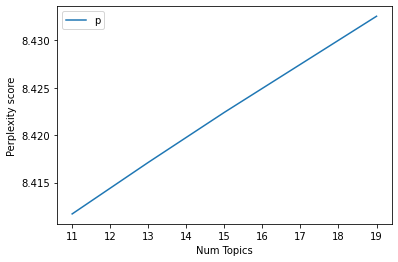

In [ ]:
import matplotlib.pyplot as plt
# Show graph
limit=20; start=11; step=2;
x = range(start, limit, step)
plt.plot(x, lp)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

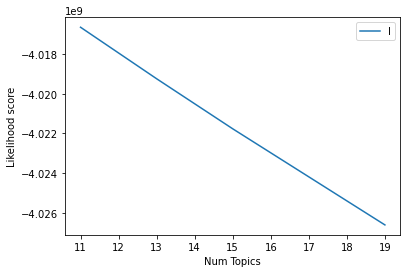

In [ ]:
import matplotlib.pyplot as plt
# Show graph
limit=20; start=11; step=2;
x = range(start, limit, step)
plt.plot(x, ll)
plt.xlabel("Num Topics")
plt.ylabel("Likelihood score")
plt.legend(("likelihood_values"), loc='best')
plt.show()


In [ ]:
# from pyspark.ml.clustering import LDA
# lda = LDA(k=13, maxIter=20, optimizer="em")
# model = lda.fit(corpus)

In [ ]:
# !hdfs dfs -copyFromLocal ~/nfs-home/lda /home/vmyslenkova-337998/lda

In [ ]:
os.getcwd()

'/home/jovyan/nfs-home'

In [ ]:
model

DistributedLDAModel: uid=LDA_8f18be303700, k=13, numFeatures=10000

In [ ]:
# lda_path = "/home/vmyslenkova-337998/models_lda.lda"
# model.save(lda_path)

In [ ]:
topicwords = 20
topics = model_1.describeTopics(topicwords)
topics.show(truncate=False)

+-----+-----------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                            |termWeights                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
tRDD = topics.rdd.map(list)
tRDD.collect()

[[0,
  [4, 0, 8, 13, 18, 2, 17, 6, 5, 21, 27, 20, 1, 7, 15, 11, 9, 37, 10, 16],
  [0.002056283031035597,
   0.001984298013357383,
   0.00187084168818089,
   0.0017449584284274478,
   0.0016124977979641874,
   0.0015826844179088902,
   0.0015693046761962389,
   0.0015247320295284025,
   0.0015240335598774263,
   0.00151740191044965,
   0.001507014653424601,
   0.001494173054533656,
   0.0014585885691273857,
   0.0014514444952953723,
   0.0014319729878308578,
   0.0014181440397238356,
   0.0013825491271296346,
   0.0013722164222474626,
   0.001369624642068522,
   0.0013612028013336055]],
 [1,
  [4, 0, 8, 13, 18, 2, 17, 5, 21, 6, 27, 20, 1, 7, 15, 11, 9, 37, 10, 16],
  [0.0020436857377679925,
   0.001980682918198238,
   0.0018405582414440713,
   0.001743453276334827,
   0.0016325145912348493,
   0.0015799240988205155,
   0.0015325138619775233,
   0.0015279059011585664,
   0.0015246673323016733,
   0.0015173774617245205,
   0.0014882348694912355,
   0.0014868340710668415,
   0.001453226668

In [ ]:
def topic_vocab(topic):
    print(topic)
    topicNum = topic[0]
    terms = topic[1]
    weight = topic[2]
    result = []
    for i in range(topicwords):
        term = vocab[terms[i]]
        out = str(topicNum)+","+term+","+str(weight[i])
        result.append(out)
  
    return result

In [ ]:
tRDD.map(lambda topic: topic_vocab(topic)).collect()

[['0,feature,0.0020515272464998358',
  '0,proposed,0.001979474674772871',
  '0,control,0.0018746428321218661',
  '0,power,0.001757004384688974',
  '0,user,0.0016166626563741573',
  '0,used,0.0015866388573058305',
  '0,learning,0.0015633534356246967',
  '0,analysis,0.0015292267581475706',
  '0,different,0.0015259570897968168',
  '0,detection,0.0015121292237893578',
  '0,energy,0.0015108352614739396',
  '0,scheme,0.0014885985595475583',
  '0,result,0.0014556010199543248',
  '0,study,0.0014536412358175893',
  '0,design,0.0014306312271145742',
  '0,process,0.001423504495011991',
  '0,two,0.0013779777135581573',
  '0,application,0.0013727020612132397',
  '0,signal,0.0013666899599850265',
  '0,technique,0.0013624829518689519'],
 ['1,feature,0.0020296795970226383',
  '1,proposed,0.0019743198690782005',
  '1,control,0.0018399106155344571',
  '1,power,0.001753081612308066',
  '1,user,0.0016400640304246178',
  '1,used,0.001579837945973406',
  '1,learning,0.001542368650146438',
  '1,different,0.0

In [ ]:
def topic_vocab_only_term(topic):
  print(topic)
  topicNum = topic[0]
  terms = topic[1]
  weight = topic[2]
  result = []
  for i in range(topicwords):
    term = vocab[terms[i]]
    out = ""+term
    result.append(out)
  
  return result

In [ ]:
list_of_term = tRDD.map(lambda topic: topic_vocab_only_term(topic)).collect()


In [ ]:
topic = tRDD.map(lambda topic: topic_vacab(topic))
corpus.show(10)

+--------------------+
|            features|
+--------------------+
|(10000,[0,9,19,23...|
|(10000,[1,2,19,24...|
|(10000,[1,2,3,16,...|
|(10000,[0,2,4,26,...|
|(10000,[0,5,10,11...|
|(10000,[0,1,2,10,...|
|(10000,[2,13,181,...|
|(10000,[1,3,7,8,1...|
|(10000,[6,14,19,2...|
|(10000,[7,11,28,2...|
+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.mllib.linalg import SparseVector, DenseVector
import math 
import operator
from collections import Counter

def get_topic_number(vector):
    list_ex = list(vector)
    list_ex = [math.trunc(i) for i in list_ex]
    list_ex = [i for i in list_ex if i != 0]
    list_ex = dict(Counter(list_ex))
    list_ex = sorted(list_ex.items(), key=operator.itemgetter(1), reverse=True)
    return list_ex[0][0]


get_topic_number_udf = F.udf(f=lambda row: get_topic_number(row), returnType=T.IntegerType())
df = rescaledData.withColumn("topic", get_topic_number_udf(F.col("features")))
df.show(10)

+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+-----+
|        author_names|          author_ids|               eid|         Description|   Description_split|         rawFeatures|            features|topic|
+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+-----+
|[Eslami, Mahdi, S...|[57220508856, 660...|2-s2.0-84865743085|common voice conv...|[common, voice, c...|(10000,[0,9,19,23...|(10000,[0,9,19,23...|    3|
|[Vaghasloo, Y. Al...|[6506911436, 3704...|2-s2.0-84863594441|size dependent st...|[size, dependent,...|(10000,[1,2,19,24...|(10000,[1,2,19,24...|    2|
|[Nejati, Mansour,...|[55359418700, 369...|2-s2.0-84856946260|digital subtracti...|[digital, subtrac...|(10000,[1,2,3,16,...|(10000,[1,2,3,16,...|    3|
|[Asvadi, Alireza,...|[54897299500, 563...|2-s2.0-84855966716|present improved ...

In [ ]:
df_1 = df.select('eid', 'topic')

In [ ]:
df_1.show()

In [ ]:
# df_1.write.save('/home/vmyslenkova-337998/labeled_dataset_two_columns.json', format='json', mode='errorifexists')

In [ ]:
df_1.write.json(path='/home/vmyslenkova-337998/labeled_dataset_two_columns_test.json')

In [ ]:
spark.stop()